<a href="https://colab.research.google.com/github/vasconcelosfer/ComputerVisionII/blob/main/TP_VPC2_V0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### TRABAJO PRACTICO FINAL

Alumnos: Fernando Vasconcelos, Victoria Teran y Lara Rosenberg

#### OBJETIVO DEL TRABAJO
Partiendo de imagenes de caras de personas, el objetivo será crear un modelo que identifique si son personas jovenes, de edad media o de edad más avanzada

In [1]:
pip install torchmetrics

In [2]:
# Importamos las librerias necesarias
import kagglehub
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os
import torch
import torchvision
import torchsummary
import torchmetrics
from torch.utils.tensorboard import SummaryWriter
import shutil
import pickle


from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# Creamos un diccionario sobre el que vamos a guardar las metricas de los modelos
models_history = {}

In [4]:
def print_results(history):
  fig, axs = plt.subplots(2, 1, figsize=(10, 10))

  axs[0].plot(history["train_loss"])
  axs[0].plot(history["valid_loss"])
  axs[0].title.set_text('Error de Entrenamiento vs Validación')
  axs[0].legend(['Train', 'Valid'])
  axs[0].grid(True)
  axs[1].plot(history["train_acc"])
  axs[1].plot(history["valid_acc"])
  axs[1].title.set_text('Accuracy de Entrenamiento vs Validación')
  axs[1].legend(['Train', 'Valid'])
  axs[1].grid(True)

In [5]:
# Descargamos el dataset
path = kagglehub.dataset_download("arashnic/faces-age-detection-dataset")

dataset_path = path + '/faces/train.csv'
image_folder_path = path + '/faces/Train'

In [6]:
# Leemos el csv que tiene el ID de las imagenes y la clase
df = pd.read_csv(dataset_path)

In [7]:
df.head()

,ID,Class
0,377.jpg,MIDDLE
1,17814.jpg,YOUNG
2,21283.jpg,MIDDLE
3,16496.jpg,YOUNG
4,4487.jpg,MIDDLE


#### Observamos que algunas imágenes del dataset no corresponden a caras de personas o su calidad es muy deficiente para ser utilizar para entrenar el modelo. A continuación mostramos unos ejemplos.

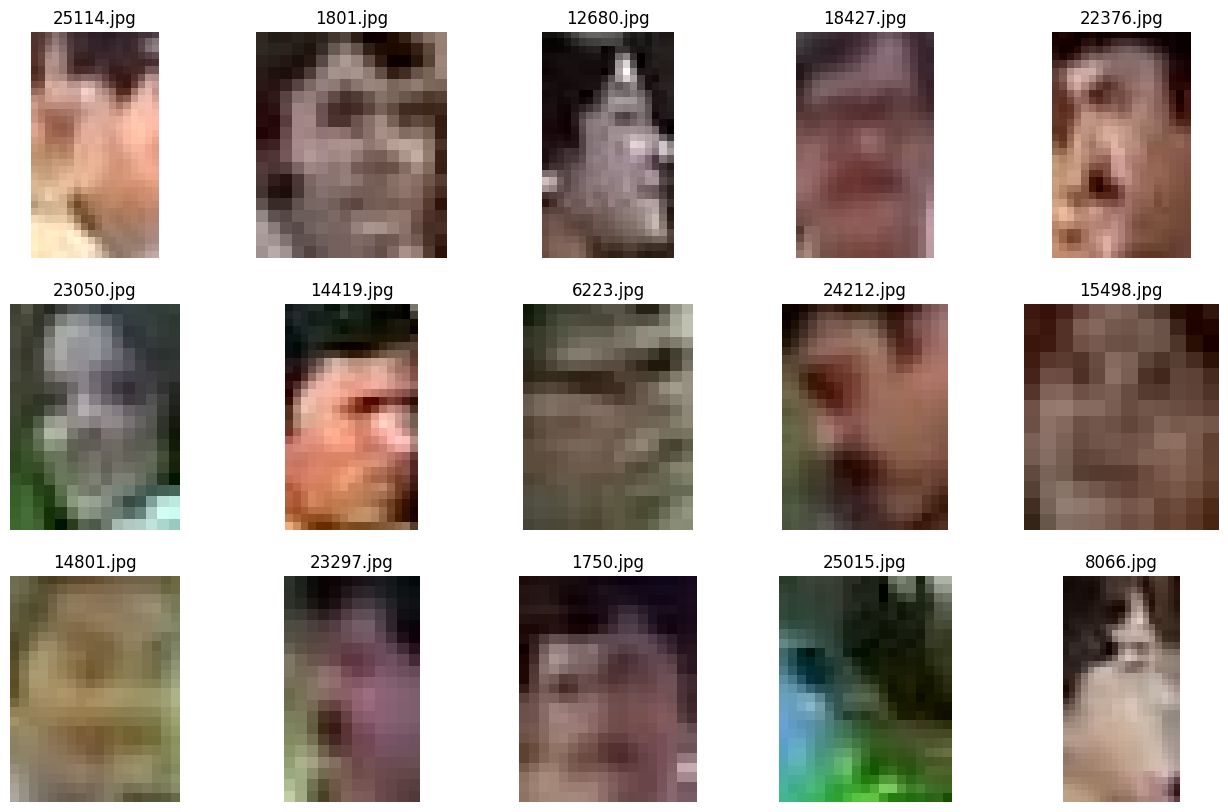

In [8]:
bad_images = ['25114.jpg', '1801.jpg', '12680.jpg', '18427.jpg', '22376.jpg', '23050.jpg', '14419.jpg', '6223.jpg', '24212.jpg', '15498.jpg','14801.jpg', '23297.jpg', '1750.jpg', '25015.jpg', '8066.jpg']

fig, axes = plt.subplots(3, 5, figsize=(16, 10))

# Iteramos sobre las 15 primeras imágenes
for i, image_file in enumerate(bad_images):
    image_path = os.path.join(image_folder_path, image_file)
    etiqueta = df[df['ID'] == image_file].iloc[0]['Class']

    with Image.open(image_path) as img:
        row = i // 5
        col = i % 5
        axes[row, col].imshow(img)
        axes[row, col].axis('off')
        axes[row, col].set_title(f'{image_file}')

A los efectos de eliminar esta imagenes se llevará a cabo un preprocesamiento del dataset con el objetivo de garantizar que todas las imágenes utilizadas contengan rostros válidos. Para ello, se empleará la herramienta MTCNN (Multi-task Cascaded Convolutional Networks) de la biblioteca facenet-pytorch (https://github.com/timesler/facenet-pytorch?tab=readme-ov-file).

MTCNN es un detector de rostros ampliamente utilizado en aplicaciones de visión por computadora debido a su capacidad para identificar y recortar caras en imágenes de manera precisa y eficiente. Esta herramienta ha sido seleccionada porque ofrece las siguientes ventajas:

Alta precisión en la detección de rostros, incluso en condiciones de iluminación variables o poses no frontales.
Velocidad y escalabilidad, con soporte para procesamiento en GPU, lo cual es esencial para manejar grandes volúmenes de datos.
Facilidad de integración, ya que es compatible con PyTorch y puede aplicarse directamente al dataset sin necesidad de configuraciones adicionales complejas.
El proceso consistirá en aplicar MTCNN sobre cada imagen del dataset. Si no se detecta ningún rostro, la imagen será eliminada del conjunto de datos. Esto permitirá asegurar que las imágenes restantes sean válidas de modo de no afectar el desempeño del modelo entrenado posteriormente.

Este paso es crucial para optimizar la calidad del dataset y garantizar la validez de los resultados obtenidos en las siguientes etapas del proyecto.

Observamos cuantas imagenes tenemos en el dataset

In [9]:
from facenet_pytorch import MTCNN
mtcnn = MTCNN()
df['face_detected'] = True
for image_file in df['ID']:
    filepath = os.path.join(image_folder_path, image_file)
    try:
        # Detecta las caras
        img = Image.open(filepath)
        boxes, _ = mtcnn.detect(img)
        if boxes is None:  # Si no se detectan caras
            df.loc[df['ID']==image_file, 'face_detected'] = False  # Almacena las imágenes sin caras
    except Exception as e:
        df.loc[df['ID']==image_file, 'face_detected'] = False

In [10]:
df.value_counts(df['face_detected'])

,count
face_detected,
True,15216
False,4690


Observamos que de las 19906, 4690 no son caras por lo tanto las eliminamos del dataset.

In [11]:
df = df[df['face_detected'] == True]
df.reset_index(inplace=True)
df = df.drop(columns=['index', 'face_detected'])

In [ ]:
# Guardamos el dataset procesado
# df.to_pickle("./df_cleaned.pkl")

In [ ]:
# Cargamos el dataframe ya filtrado
df = pd.read_pickle('./df_cleaned.pkl')

In [12]:
df.shape

(15216, 2)

Evaluamos la distribucion de las clases

In [13]:
df.Class.value_counts()

,count
Class,
MIDDLE,7866
YOUNG,5655
OLD,1695


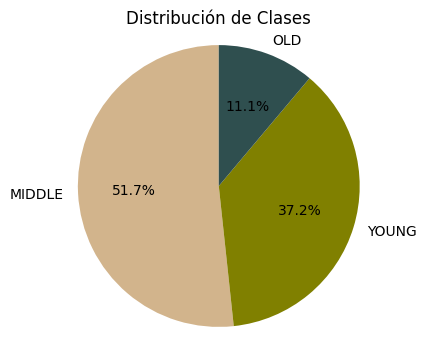

In [14]:
# Creamos el gráfico de torta
plt.figure(figsize=(4, 4))
plt.pie(df.Class.value_counts(), labels=df.Class.value_counts().index, autopct='%1.1f%%', startangle=90, colors=['tan', 'olive','darkslategrey'])
plt.axis('equal')

# Agregamos un título
plt.title('Distribución de Clases')

# Mostramos el gráfico
plt.show()

Como podemos ver, las clases se encuentran desbalanceadas.
Más de la mitad de las imagenes, son clasificadas como "middle".
Solo un 12% de las observaciones, corresponden a edades más avanzadas ("old")

Lo primero que vamos a hacer es revisar si todas las imagenes tienen el mismo tamaño

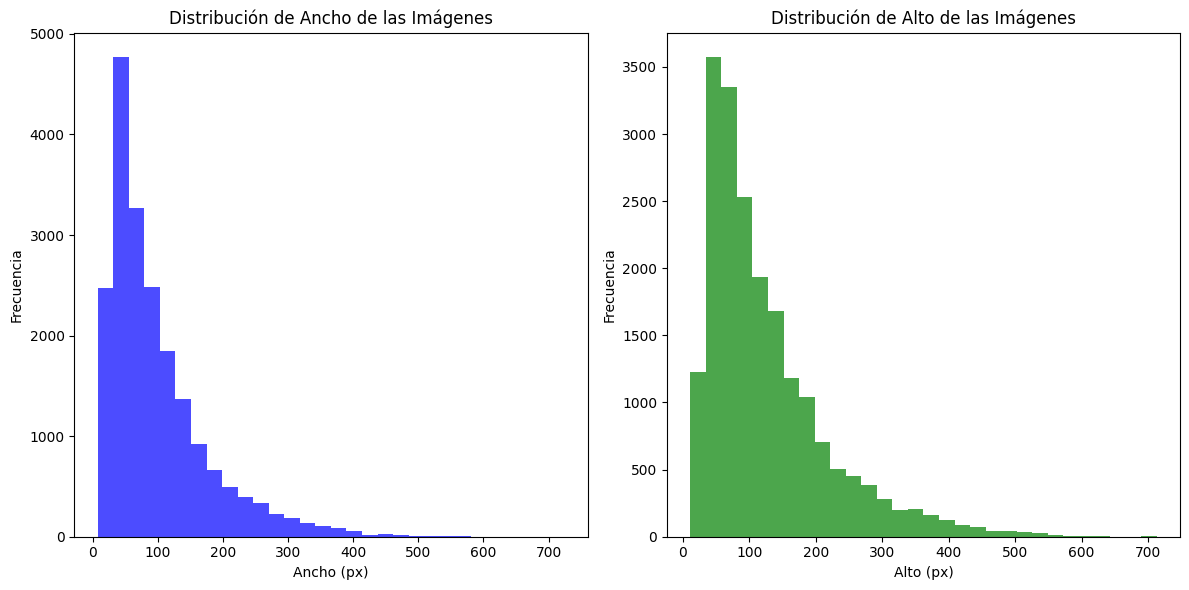

In [15]:
# Obtenemos todos los archivos de la carpeta
image_files = os.listdir(image_folder_path)

# Iniciamos listas para almacenar los valores de ancho y alto
widths = []
heights = []
image_sizes = []

# Iteramos sobre los archivos de la carpeta
for image_file in image_files:
    image_path = os.path.join(image_folder_path, image_file)
    with Image.open(image_path) as img:
        width, height = img.size
        image_sizes.append(img.size)
        widths.append(width)
        heights.append(height)

# Creamos los gráficos de distribución para ancho y alto
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Histograma del ancho de las imágenes
axes[0].hist(widths, bins=30, color='blue', alpha=0.7)
axes[0].set_title('Distribución de Ancho de las Imágenes')
axes[0].set_xlabel('Ancho (px)')
axes[0].set_ylabel('Frecuencia')

# Histograma del alto de las imágenes
axes[1].hist(heights, bins=30, color='green', alpha=0.7)
axes[1].set_title('Distribución de Alto de las Imágenes')
axes[1].set_xlabel('Alto (px)')
axes[1].set_ylabel('Frecuencia')

# Mostramos los gráficos
plt.tight_layout()
plt.show()

Como podemos ver, las imagenes presentan distintos tamaños, es decir, no son homogeneas.

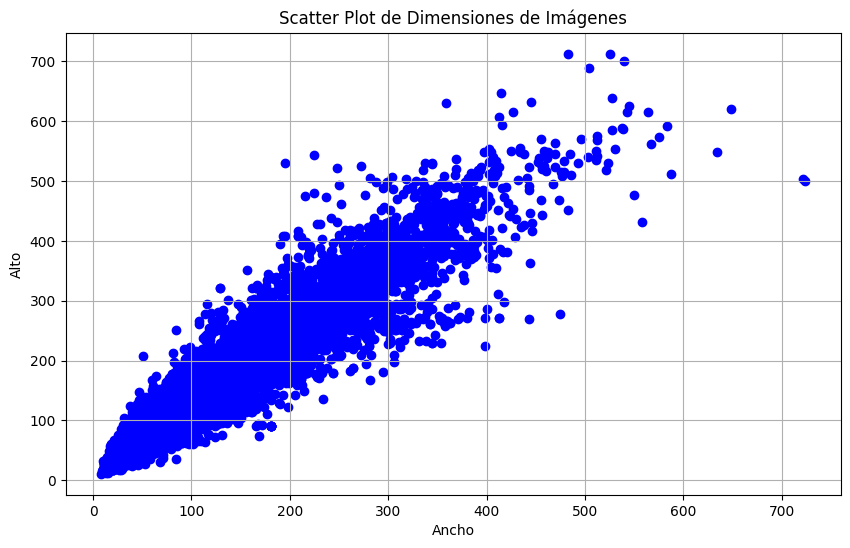

In [16]:
widths, heights = zip(*image_sizes)

# Creamos el scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(widths, heights, color='blue', marker='o')

# Configuramos el título y las etiquetas
plt.title('Scatter Plot de Dimensiones de Imágenes')
plt.xlabel('Ancho')
plt.ylabel('Alto')
plt.grid(True)

# Mostramos el plot
plt.show()

Como podemos ver, las imágenes no son cuadradas (suelen tener más largo que ancho).

Observamos las primeras 15 imagenes

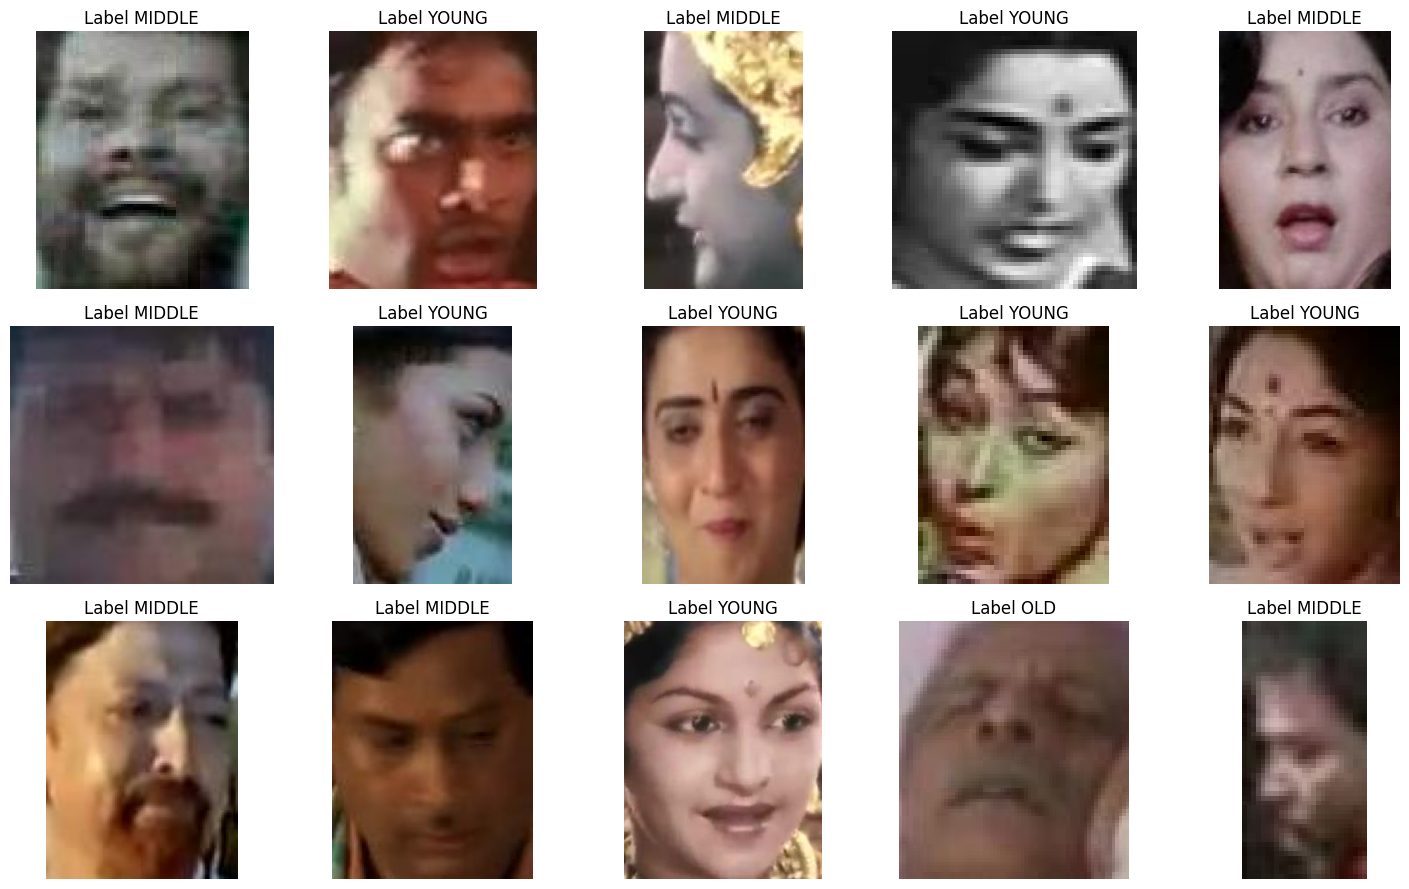

In [17]:
# Obtenemos las primeras 15 imágenes
first_15_images = df['ID'][:15]

fig, axes = plt.subplots(3, 5, figsize=(15, 9))

# Iteramos sobre las 15 primeras imágenes
for i, image_file in enumerate(first_15_images):
    image_path = os.path.join(image_folder_path, image_file)
    etiqueta = df[df['ID'] == image_file].iloc[0]['Class']

    with Image.open(image_path) as img:
        row = i // 5
        col = i % 5
        axes[row, col].imshow(img)
        axes[row, col].axis('off')
        axes[row, col].set_title(f'Label {etiqueta}')

# Ajustamos el espacio entre las subgráficas
plt.tight_layout()

# Mostramos el gráfico
plt.show()

In [18]:
# Data Preprocessing --> cambiamos los labels de str a int
class_mapping = {'YOUNG': 0, 'MIDDLE': 1, 'OLD': 2}
df['Class'] = df['Class'].map(class_mapping)

In [19]:
# Dividimos los datos en conjuntos de entrenamiento y validación
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['Class'])

print(f'Tamaño conjunto de entrenamiento: {len(train_df)}')
print(f'Tamaño conjunto de validacion: {len(valid_df)}')

Tamaño conjunto de entrenamiento: 12172
Tamaño conjunto de validacion: 3044


In [20]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, images_dir, transform=None):
        self.dataframe = dataframe
        self.images_dir = images_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = self.dataframe.iloc[idx, 0]  # Nombre de la imagen (ID)
        label = self.dataframe.iloc[idx, 1]     # Clase correspondiente
        img_path = os.path.join(self.images_dir, img_name)

        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

Tamaño original de la imagen: 309x387


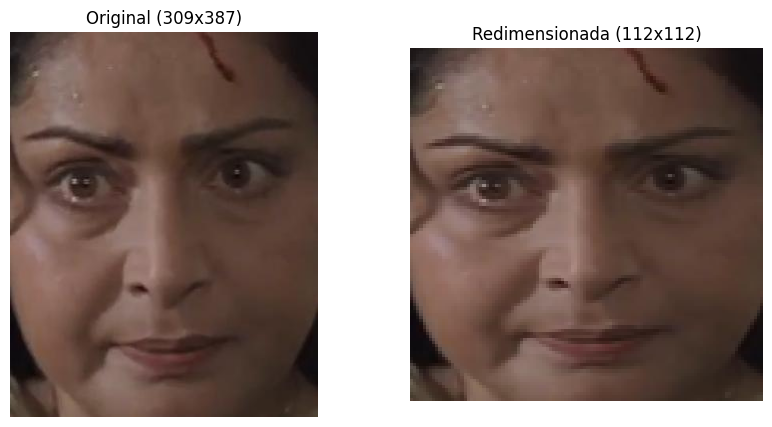

In [21]:
# Cargamos la imagen original
img_path = image_folder_path + '/1.jpg'
original_image = Image.open(img_path)

# Mostramos las dimensiones de la imagen original
original_size = original_image.size
print(f"Tamaño original de la imagen: {original_size[0]}x{original_size[1]}")

# Definimos el tamaño del resize
resize_transform = transforms.Resize((112, 112), interpolation=Image.LANCZOS)

# Aplicamos la transformación sobre la imagen
resized_image = resize_transform(original_image)

# Mostramos las imágenes: original y redimensionada
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(original_image)
axes[0].set_title(f"Original ({original_size[0]}x{original_size[1]})")
axes[0].axis("off")

resized_size = resized_image.size
axes[1].imshow(resized_image)
axes[1].set_title(f"Redimensionada ({resized_size[0]}x{resized_size[1]})")
axes[1].axis("off")

plt.show()

In [22]:
# Definimos la cantidad de clases del problema
CANTIDAD_CLASES = 3
ANCHO_IMAGENES = 112
ALTO_IMAGENES = 112

In [23]:
transform = transforms.Compose([
    transforms.Resize((ANCHO_IMAGENES, ALTO_IMAGENES), interpolation=Image.LANCZOS),
    transforms.ToTensor(),
])

In [24]:
# Creamos los datasets
train_dataset = CustomDataset(dataframe=train_df, images_dir=image_folder_path, transform=transform)
valid_dataset = CustomDataset(dataframe=valid_df, images_dir=image_folder_path, transform=transform)

# Creamos los dataloaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)

# 1. ARQUITECTURA BASICA

In [ ]:
class ConvModel(torch.nn.Module):
    def __init__(self, output_units, dropout_ratio=0.4, dropout2d_ratio=0.3):
        super().__init__()
        self.dropout2d = torch.nn.Dropout2d(dropout2d_ratio)
        self.dropout = torch.nn.Dropout(p=dropout_ratio)

        self.conv1 = torch.nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding='same')
        self.bn1 = torch.nn.BatchNorm2d(16)
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding='same')
        self.bn2 = torch.nn.BatchNorm2d(32)
        self.pool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding='same')
        self.bn3 = torch.nn.BatchNorm2d(64)
        self.pool3 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv4 = torch.nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding='same')
        self.bn4 = torch.nn.BatchNorm2d(128)
        self.pool4 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv5 = torch.nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding='same')
        self.bn5  = torch.nn.BatchNorm2d(256)
        self.pool5 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = torch.nn.Linear(in_features=2304, out_features=256)
        self.fc2 = torch.nn.Linear(in_features=256, out_features=output_units)

    def forward(self, x):
        x = self.pool1(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool2(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool3(torch.relu(self.bn3(self.conv3(x))))
        x = self.dropout2d(x)
        x = self.pool4(torch.relu(self.bn4(self.conv4(x))))
        x = self.dropout2d(x)
        x = self.pool5(torch.relu(self.bn5(self.conv5(x))))
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

conv_model = ConvModel(CANTIDAD_CLASES)

# Si hay una GPU disponible muevo el modelo allí para aprovechar ese recurso
if torch.cuda.is_available():
    conv_model.to("cuda")

torchsummary.summary(conv_model, (3, ANCHO_IMAGENES, ALTO_IMAGENES))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 112, 112]             448
       BatchNorm2d-2         [-1, 16, 112, 112]              32
         MaxPool2d-3           [-1, 16, 56, 56]               0
            Conv2d-4           [-1, 32, 56, 56]           4,640
       BatchNorm2d-5           [-1, 32, 56, 56]              64
         MaxPool2d-6           [-1, 32, 28, 28]               0
            Conv2d-7           [-1, 64, 28, 28]          18,496
       BatchNorm2d-8           [-1, 64, 28, 28]             128
         MaxPool2d-9           [-1, 64, 14, 14]               0
        Dropout2d-10           [-1, 64, 14, 14]               0
           Conv2d-11          [-1, 128, 14, 14]          73,856
      BatchNorm2d-12          [-1, 128, 14, 14]             256
        MaxPool2d-13            [-1, 128, 7, 7]               0
        Dropout2d-14            [-1, 12

In [38]:
def train(model, optimizer, criterion, metric, data, epochs, tb_writer=None):

    train_loader = data["train"]
    valid_loader = data["valid"]

    if tb_writer:
      train_writer = tb_writer["train"]
      valid_writer = tb_writer["valid"]
      train_writer.add_graph(model, torch.zeros((1, 3, data["image_width"], data["image_height"])))
      valid_writer.add_graph(model, torch.zeros((1, 3, data["image_width"], data["image_height"])))

    # if torch.cuda.is_available():
    #     model.to("cuda")
    #     metric.to("cuda")


    model.to(device)
    metric.to(device)

    train_loss = []
    train_acc = []
    valid_loss = []
    valid_acc = []

    for epoch in range(epochs):

        # Pongo el modelo en modo entrenamiento
        model.train()

        epoch_train_loss = 0.0
        epoch_train_accuracy = 0.0

        for train_data, train_target in train_loader:

            # if torch.cuda.is_available():
            #     train_data = train_data.to("cuda")
            #     train_target = train_target.to("cuda")

            train_data = train_data.to(device)
            train_target = train_target.to(device)

            optimizer.zero_grad()
            output = model(train_data.float())
            loss = criterion(output, train_target)
            epoch_train_loss += loss.item()
            loss.backward()
            optimizer.step()

            accuracy = metric(output, train_target)
            epoch_train_accuracy += accuracy.item()

        epoch_train_loss = epoch_train_loss / len(train_loader)
        epoch_train_accuracy = epoch_train_accuracy / len(train_loader)
        train_loss.append(epoch_train_loss)
        train_acc.append(epoch_train_accuracy)

        # Pongo el modelo en modo testeo
        model.eval()

        epoch_valid_loss = 0.0
        epoch_valid_accuracy = 0.0

        for valid_data, valid_target in valid_loader:
            if torch.cuda.is_available():
                valid_data = valid_data.to("cuda")
                valid_target = valid_target.to("cuda")

            output = model(valid_data.float())
            epoch_valid_loss += criterion(output, valid_target).item()
            epoch_valid_accuracy += metric(output, valid_target).item()

        epoch_valid_loss = epoch_valid_loss / len(valid_loader)
        epoch_valid_accuracy = epoch_valid_accuracy / len(valid_loader)
        valid_loss.append(epoch_valid_loss)
        valid_acc.append(epoch_valid_accuracy)

        print("Epoch: {}/{} - Train loss {:.6f} - Train Accuracy {:.6f} - Valid Loss {:.6f} - Valid Accuracy {:.6f}".format(
        epoch+1, epochs, epoch_train_loss, epoch_train_accuracy, epoch_valid_loss, epoch_valid_accuracy))

        if tb_writer:
            train_writer.add_scalar("loss", epoch_train_loss, epoch)
            valid_writer.add_scalar("loss", epoch_valid_loss, epoch)
            train_writer.add_scalar("accuracy", epoch_train_accuracy, epoch)
            valid_writer.add_scalar("accuracy", epoch_valid_accuracy, epoch)
            train_writer.flush()
            valid_writer.flush()

    history = {}
    history["train_loss"] = train_loss
    history["train_acc"] = train_acc
    history["valid_loss"] = valid_loss
    history["valid_acc"] = valid_acc

    return history

In [39]:
# Dado que las clases se encuentran desbalanceadas vamos a utilizar el argumento weight de CrossEntropy
class_counts = np.bincount(train_dataset.dataframe.Class)
class_weights = 1. / class_counts  # Invertimos la frecuencia para dar más peso a las clases menos frecuentes
class_weights = class_weights / class_weights.sum()
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

In [ ]:
noaug_conv_model = ConvModel(CANTIDAD_CLASES, dropout_ratio=0.4, dropout2d_ratio=0.3)
noaug_optimizer = torch.optim.Adam(noaug_conv_model.parameters(), lr=0.001, weight_decay=0.001)
noaug_loss = torch.nn.CrossEntropyLoss(weight=class_weights_tensor)
noaug_metric = torchmetrics.Accuracy(task='multiclass', num_classes=CANTIDAD_CLASES,average='macro')
noaug_data = {"train": train_loader, "valid": valid_loader, "image_width": ANCHO_IMAGENES, "image_height": ALTO_IMAGENES}

noaug_writer = {"train": SummaryWriter(log_dir="data_aug/noaug_train"),
                "valid": SummaryWriter(log_dir="data_aug/noaug_valid")}

history = train(noaug_conv_model,
                noaug_optimizer,
                noaug_loss,
                noaug_metric,
                noaug_data,
                20,
                None)

Epoch: 1/20 - Train loss 0.946663 - Train Accuracy 0.550334 - Valid Loss 0.841806 - Valid Accuracy 0.612589
Epoch: 2/20 - Train loss 0.816764 - Train Accuracy 0.635459 - Valid Loss 0.818910 - Valid Accuracy 0.622302
Epoch: 3/20 - Train loss 0.745402 - Train Accuracy 0.676962 - Valid Loss 0.723487 - Valid Accuracy 0.696024
Epoch: 4/20 - Train loss 0.708042 - Train Accuracy 0.701619 - Valid Loss 0.682364 - Valid Accuracy 0.704401
Epoch: 5/20 - Train loss 0.683619 - Train Accuracy 0.718859 - Valid Loss 0.758368 - Valid Accuracy 0.678832
Epoch: 6/20 - Train loss 0.665664 - Train Accuracy 0.722744 - Valid Loss 0.646251 - Valid Accuracy 0.731879
Epoch: 7/20 - Train loss 0.657068 - Train Accuracy 0.730228 - Valid Loss 0.634427 - Valid Accuracy 0.737643
Epoch: 8/20 - Train loss 0.614696 - Train Accuracy 0.748060 - Valid Loss 0.610774 - Valid Accuracy 0.744559
Epoch: 9/20 - Train loss 0.599472 - Train Accuracy 0.755670 - Valid Loss 0.656520 - Valid Accuracy 0.725736
Epoch: 10/20 - Train loss 0.

In [ ]:
model_name = "conv_only"
models_history[model_name] = history


In [ ]:
print_results(history)

# 2. DATA AUGMENTATION

Como estamos trabajando con imágenes de caras de personas, es importante asegurarnos de que las transformaciones no distorsionen los rasgos faciales. Por ejemplo, hacer una rotación demasiado grande o un escalado excesivo podría alterar la posición de los ojos, la nariz o la boca, lo cual podría hacer que el modelo no aprenda correctamente.

Transformaciones propuestas:

transforms.RandomHorizontalFlip:
Refleja las caras horizontalmente sin perder ningún detalle relevante. Esto puede ayudar al modelo a aprender a reconocer las caras sin importar la dirección en la que están orientadas. Uso: transforms.RandomHorizontalFlip(p=0.5) (50% de probabilidad de hacer el flip).

transforms.RandomRotation:
Las rotaciones moderadas pensamos que pueden ser útiles en este caso. Uso: transforms.RandomRotation(degrees=15) (esto permite rotaciones aleatorias de hasta 15 grados en ambas direcciones).

transforms.ColorJitter:
Esta transformación ajusta aleatoriamente el brillo, contraste, saturación y tonalidad de la imagen. Ayuda a hacer que el modelo sea robusto frente a variaciones de iluminación y color en las caras. Uso: transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1).

In [26]:
aug_data_transforms = torchvision.transforms.Compose([
                        torchvision.transforms.Resize((ANCHO_IMAGENES, ALTO_IMAGENES), interpolation=Image.LANCZOS),
                        torchvision.transforms.RandomHorizontalFlip(0.5),
                        torchvision.transforms.RandomRotation(degrees=25),
                        torchvision.transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
                        torchvision.transforms.ToTensor(),
                      ])

In [27]:
transforms = torchvision.transforms.Compose([
                    torchvision.transforms.Resize((ANCHO_IMAGENES, ALTO_IMAGENES), interpolation=Image.LANCZOS),
                    torchvision.transforms.ToTensor()
                  ])

# Creamos los Datasets
aug_train_set = CustomDataset(dataframe=train_df, images_dir=image_folder_path, transform=aug_data_transforms)
aug_valid_set = CustomDataset(dataframe=valid_df, images_dir=image_folder_path, transform=transforms)

# Creamos los DataLoaders
aug_train_loader = DataLoader(aug_train_set, batch_size=64, shuffle=True)
aug_valid_loader = DataLoader(aug_valid_set, batch_size=64, shuffle=False)


In [ ]:
aug_conv_model = ConvModel(CANTIDAD_CLASES, dropout_ratio=0.2, dropout2d_ratio=0.1)
aug_optimizer = torch.optim.Adam(aug_conv_model.parameters(),lr=0.001, weight_decay=0.0001)
aug_loss = torch.nn.CrossEntropyLoss(weight=class_weights_tensor)
aug_metric = torchmetrics.Accuracy(task='multiclass', num_classes=CANTIDAD_CLASES,average='macro')
aug_data = {"train": aug_train_loader, "valid": aug_valid_loader, "image_width": ANCHO_IMAGENES, "image_height": ALTO_IMAGENES}

aug_writer = {"train": SummaryWriter(log_dir="data_aug/aug_train"),
              "valid": SummaryWriter(log_dir="data_aug/aug_valid")}

history = train(aug_conv_model,
                aug_optimizer,
                aug_loss,
                aug_metric,
                aug_data,
                40,
                None)

Epoch: 1/40 - Train loss 1.009739 - Train Accuracy 0.497319 - Valid Loss 0.953386 - Valid Accuracy 0.512458
Epoch: 2/40 - Train loss 0.868949 - Train Accuracy 0.608105 - Valid Loss 0.807980 - Valid Accuracy 0.664065
Epoch: 3/40 - Train loss 0.801983 - Train Accuracy 0.644420 - Valid Loss 0.748863 - Valid Accuracy 0.678004
Epoch: 4/40 - Train loss 0.772714 - Train Accuracy 0.659681 - Valid Loss 0.698544 - Valid Accuracy 0.710059
Epoch: 5/40 - Train loss 0.737792 - Train Accuracy 0.679907 - Valid Loss 0.673783 - Valid Accuracy 0.722064
Epoch: 6/40 - Train loss 0.715233 - Train Accuracy 0.694299 - Valid Loss 0.702770 - Valid Accuracy 0.695845
Epoch: 7/40 - Train loss 0.694194 - Train Accuracy 0.706141 - Valid Loss 0.689652 - Valid Accuracy 0.726817
Epoch: 8/40 - Train loss 0.690368 - Train Accuracy 0.709082 - Valid Loss 0.627518 - Valid Accuracy 0.733555
Epoch: 9/40 - Train loss 0.660166 - Train Accuracy 0.726091 - Valid Loss 0.646396 - Valid Accuracy 0.728641
Epoch: 10/40 - Train loss 0.

In [ ]:
model_name = "conv_dag"
models_history[model_name] = history

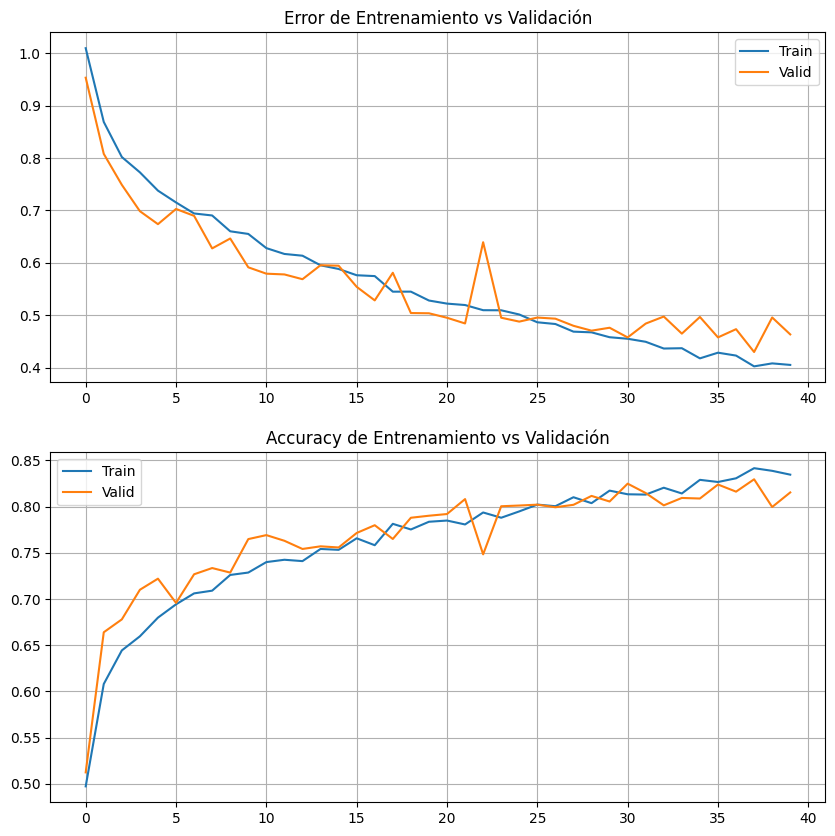

In [ ]:
print_results(history)

In [31]:
def check_requires_grad(model):
    for name, param in model.named_parameters():
        print(f'{name}: requires_grad = {param.requires_grad}')

# 3. TRANSFER LEARNING VGG19 MODIFICANDO UNICAMENTE LA CAPA FULLY CONNECTED

In [ ]:
from torchvision.models.vgg import VGG19_Weights

weights = VGG19_Weights.IMAGENET1K_V1
transforms = weights.transforms()

In [ ]:
vgg19_model = torchvision.models.vgg19(weights=weights)

vgg19_model.to("cuda")

print(vgg19_model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [ ]:
#Congelamos todas las capas excepto la fully connected
for param in vgg19_model.parameters():
    param.requires_grad = False

#Cambiamos el output de la fully connected ajustandolo a nuestro problema de clasificacion
last_layer_in_features = vgg19_model.classifier[-1].in_features
vgg19_model.classifier[-1] = torch.nn.Linear(in_features=last_layer_in_features, out_features=CANTIDAD_CLASES)


check_requires_grad(vgg19_model)

features.0.weight: requires_grad = False
features.0.bias: requires_grad = False
features.2.weight: requires_grad = False
features.2.bias: requires_grad = False
features.5.weight: requires_grad = False
features.5.bias: requires_grad = False
features.7.weight: requires_grad = False
features.7.bias: requires_grad = False
features.10.weight: requires_grad = False
features.10.bias: requires_grad = False
features.12.weight: requires_grad = False
features.12.bias: requires_grad = False
features.14.weight: requires_grad = False
features.14.bias: requires_grad = False
features.16.weight: requires_grad = False
features.16.bias: requires_grad = False
features.19.weight: requires_grad = False
features.19.bias: requires_grad = False
features.21.weight: requires_grad = False
features.21.bias: requires_grad = False
features.23.weight: requires_grad = False
features.23.bias: requires_grad = False
features.25.weight: requires_grad = False
features.25.bias: requires_grad = False
features.28.weight: requ

Epoch: 1/15 - Train loss 1.046670 - Train Accuracy 0.452021 - Valid Loss 0.996047 - Valid Accuracy 0.484729
Epoch: 2/15 - Train loss 0.998417 - Train Accuracy 0.500814 - Valid Loss 0.983624 - Valid Accuracy 0.480882
Epoch: 3/15 - Train loss 0.984285 - Train Accuracy 0.513314 - Valid Loss 0.975060 - Valid Accuracy 0.501936
Epoch: 4/15 - Train loss 0.962491 - Train Accuracy 0.524120 - Valid Loss 0.967915 - Valid Accuracy 0.498791
Epoch: 5/15 - Train loss 0.966781 - Train Accuracy 0.523100 - Valid Loss 0.968369 - Valid Accuracy 0.505560
Epoch: 6/15 - Train loss 0.956800 - Train Accuracy 0.531739 - Valid Loss 0.967974 - Valid Accuracy 0.498176
Epoch: 7/15 - Train loss 0.956770 - Train Accuracy 0.536992 - Valid Loss 0.955354 - Valid Accuracy 0.506804
Epoch: 8/15 - Train loss 0.957224 - Train Accuracy 0.531258 - Valid Loss 0.959398 - Valid Accuracy 0.498576
Epoch: 9/15 - Train loss 0.944188 - Train Accuracy 0.543339 - Valid Loss 0.950889 - Valid Accuracy 0.504575
Epoch: 10/15 - Train loss 0.

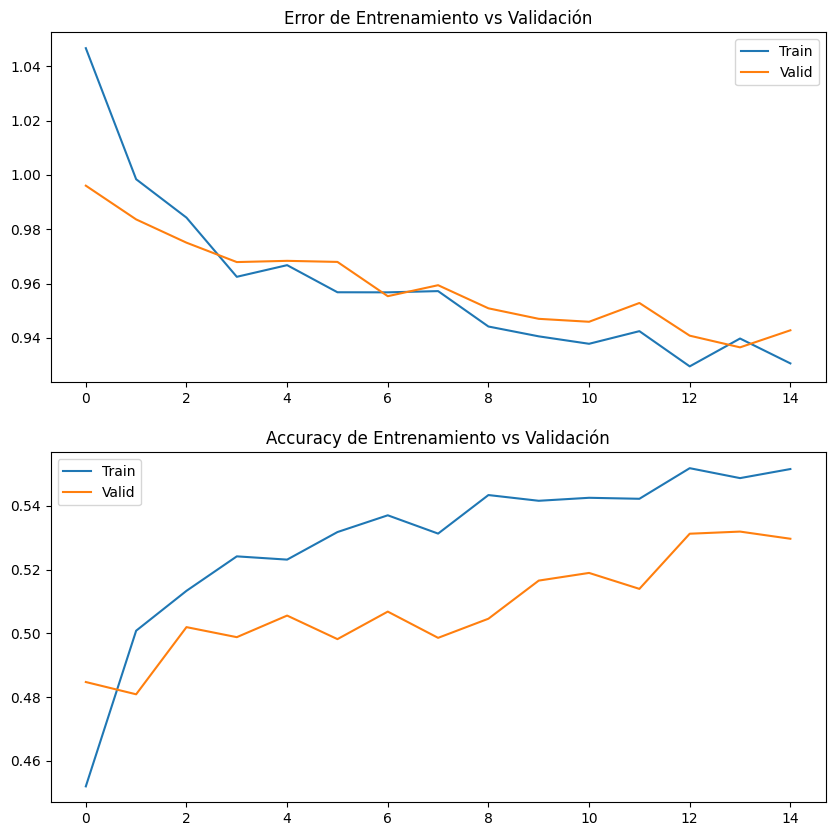

In [ ]:
%%time

optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, vgg19_model.parameters()),lr=0.0001)
loss = torch.nn.CrossEntropyLoss(weight=class_weights_tensor)
metric = torchmetrics.Accuracy(task='multiclass', num_classes=CANTIDAD_CLASES,average='macro' )
data = {"train": aug_train_loader, "valid": aug_valid_loader, "image_width": ANCHO_IMAGENES, "image_height": ALTO_IMAGENES}


history = train(vgg19_model.to('cpu'),
                optimizer,
                loss,
                metric,
                data,
                15)

fig, axs = plt.subplots(2, 1, figsize=(10, 10))

axs[0].plot(history["train_loss"])
axs[0].plot(history["valid_loss"])
axs[0].title.set_text('Error de Entrenamiento vs Validación')
axs[0].legend(['Train', 'Valid'])

axs[1].plot(history["train_acc"])
axs[1].plot(history["valid_acc"])
axs[1].title.set_text('Accuracy de Entrenamiento vs Validación')
axs[1].legend(['Train', 'Valid'])



In [ ]:
model_name = "vgg19_fc"
models_history[model_name] = history
data.update(models_history)

# 4. TRANSFER LEARNING RESNET18 MODIFICANDO UNICAMENTE LA CAPA FULLY CONNECTED

In [ ]:
from torchvision.models import resnet18, ResNet18_Weights

weights = ResNet18_Weights.IMAGENET1K_V1
transforms = weights.transforms()

In [ ]:
resnet18_model = resnet18(weights=weights)

resnet18_model.to("cuda")

print(resnet18_model)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 195MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
#Congelamos todas las capas excepto la fully connected
for param in resnet18_model.parameters():
    param.requires_grad = False

#Cambiamos el output de la fully connected ajustandolo a nuestro problema de clasificacion
last_layer_in_features = resnet18_model.fc.in_features
resnet18_model.fc = torch.nn.Linear(in_features=last_layer_in_features, out_features=CANTIDAD_CLASES)


check_requires_grad(resnet18_model)

conv1.weight: requires_grad = False
bn1.weight: requires_grad = False
bn1.bias: requires_grad = False
layer1.0.conv1.weight: requires_grad = False
layer1.0.bn1.weight: requires_grad = False
layer1.0.bn1.bias: requires_grad = False
layer1.0.conv2.weight: requires_grad = False
layer1.0.bn2.weight: requires_grad = False
layer1.0.bn2.bias: requires_grad = False
layer1.1.conv1.weight: requires_grad = False
layer1.1.bn1.weight: requires_grad = False
layer1.1.bn1.bias: requires_grad = False
layer1.1.conv2.weight: requires_grad = False
layer1.1.bn2.weight: requires_grad = False
layer1.1.bn2.bias: requires_grad = False
layer2.0.conv1.weight: requires_grad = False
layer2.0.bn1.weight: requires_grad = False
layer2.0.bn1.bias: requires_grad = False
layer2.0.conv2.weight: requires_grad = False
layer2.0.bn2.weight: requires_grad = False
layer2.0.bn2.bias: requires_grad = False
layer2.0.downsample.0.weight: requires_grad = False
layer2.0.downsample.1.weight: requires_grad = False
layer2.0.downsample.

Epoch: 1/15 - Train loss 1.124362 - Train Accuracy 0.397821 - Valid Loss 1.121638 - Valid Accuracy 0.387525
Epoch: 2/15 - Train loss 1.049398 - Train Accuracy 0.463573 - Valid Loss 1.087713 - Valid Accuracy 0.425933
Epoch: 3/15 - Train loss 1.002272 - Train Accuracy 0.504682 - Valid Loss 1.061730 - Valid Accuracy 0.437656
Epoch: 4/15 - Train loss 0.981737 - Train Accuracy 0.513334 - Valid Loss 1.037247 - Valid Accuracy 0.465668
Epoch: 5/15 - Train loss 0.965398 - Train Accuracy 0.534009 - Valid Loss 1.019004 - Valid Accuracy 0.477787
Epoch: 6/15 - Train loss 0.951251 - Train Accuracy 0.547233 - Valid Loss 1.013994 - Valid Accuracy 0.480232
Epoch: 7/15 - Train loss 0.936808 - Train Accuracy 0.550980 - Valid Loss 1.011442 - Valid Accuracy 0.484016
Epoch: 8/15 - Train loss 0.923425 - Train Accuracy 0.569078 - Valid Loss 0.994921 - Valid Accuracy 0.496153
Epoch: 9/15 - Train loss 0.931485 - Train Accuracy 0.556556 - Valid Loss 0.990771 - Valid Accuracy 0.501154
Epoch: 10/15 - Train loss 0.

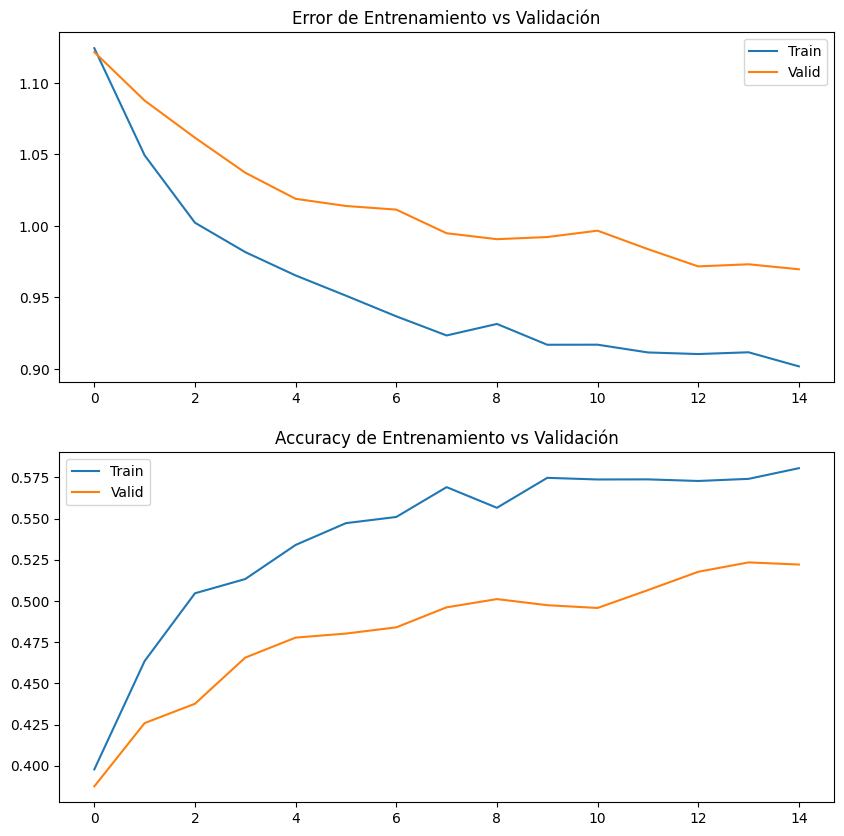

In [ ]:
%%time

optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, resnet18_model.parameters()),lr=0.0001)
loss = torch.nn.CrossEntropyLoss(weight=class_weights_tensor)
metric = torchmetrics.Accuracy(task='multiclass', num_classes=CANTIDAD_CLASES,average='macro' )
data = {"train": aug_train_loader, "valid": aug_valid_loader, "image_width": ANCHO_IMAGENES, "image_height": ALTO_IMAGENES}


history = train(resnet18_model.to('cpu'),
                optimizer,
                loss,
                metric,
                data,
                15)

fig, axs = plt.subplots(2, 1, figsize=(10, 10))

axs[0].plot(history["train_loss"])
axs[0].plot(history["valid_loss"])
axs[0].title.set_text('Error de Entrenamiento vs Validación')
axs[0].legend(['Train', 'Valid'])

axs[1].plot(history["train_acc"])
axs[1].plot(history["valid_acc"])
axs[1].title.set_text('Accuracy de Entrenamiento vs Validación')
axs[1].legend(['Train', 'Valid'])



In [ ]:
model_name = "resnet18_fc"
models_history[model_name] = history

# 5. TRANSFER LEARNING RESNET18 MODIFICANDO LA ULTIMA CAPA CONVOLUSIONAL Y AGREGANDO DROPOUT

In [ ]:
weights = ResNet18_Weights.IMAGENET1K_V1
transforms = weights.transforms()

In [ ]:
resnet18_model = resnet18(weights=weights)

resnet18_model.to("cuda")

print(resnet18_model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# Congelamos todas las capas inicialmente
for param in resnet18_model.parameters():
    param.requires_grad = False

# Descongelamos las capas del último bloque (layer4)
for layer in resnet18_model.layer4:
    for param in layer.parameters():
        param.requires_grad = True  # Habilitar el entrenamiento para las capas de layer4

# Descongelamos la capa final (fc) y la adaptamos
last_layer_in_features = resnet18_model.fc.in_features
resnet18_model.fc = torch.nn.Linear(in_features=last_layer_in_features, out_features=CANTIDAD_CLASES)

# Definimos un bloque básico modificado que incluye Dropout
class BasicBlockWithDropout(torch.nn.Module):

    def __init__(self, in_channels, out_channels, stride=1, downsample=None, dropout_prob=0.5):
        super(BasicBlockWithDropout, self).__init__()
        self.conv1 = torch.nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = torch.nn.BatchNorm2d(out_channels)
        self.relu = torch.nn.ReLU(inplace=True)
        self.dropout = torch.nn.Dropout(p=dropout_prob)
        self.conv2 = torch.nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = torch.nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.dropout(out)  # Aplicamos Dropout después de la ReLU

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

# Reemplazamos el layer4 en el modelo con bloques que contienen Dropout
class ModifiedResNet18(torch.nn.Module):
    def __init__(self, original_model):
        super(ModifiedResNet18, self).__init__()
        self.resnet = original_model

        # Reemplazamos layer4 con bloques que contienen Dropout
        self.resnet.layer4 = self._replace_with_dropout(self.resnet.layer4)

    def _replace_with_dropout(self, layer4):
        new_layer4 = []
        for block in layer4:
            in_channels = block.conv1.in_channels
            out_channels = block.conv2.out_channels
            stride = block.stride
            downsample = block.downsample

            # Creamos el nuevo bloque con Dropout
            new_block = BasicBlockWithDropout(in_channels, out_channels, stride=stride, downsample=downsample, dropout_prob=0.5)
            new_layer4.append(new_block)

        return torch.nn.Sequential(*new_layer4)

    def forward(self, x):
        return self.resnet(x)

# Creamos el modelo modificado
resnet18_model_mod = ModifiedResNet18(resnet18_model)


check_requires_grad(resnet18_model_mod)

resnet.conv1.weight: requires_grad = False
resnet.bn1.weight: requires_grad = False
resnet.bn1.bias: requires_grad = False
resnet.layer1.0.conv1.weight: requires_grad = False
resnet.layer1.0.bn1.weight: requires_grad = False
resnet.layer1.0.bn1.bias: requires_grad = False
resnet.layer1.0.conv2.weight: requires_grad = False
resnet.layer1.0.bn2.weight: requires_grad = False
resnet.layer1.0.bn2.bias: requires_grad = False
resnet.layer1.1.conv1.weight: requires_grad = False
resnet.layer1.1.bn1.weight: requires_grad = False
resnet.layer1.1.bn1.bias: requires_grad = False
resnet.layer1.1.conv2.weight: requires_grad = False
resnet.layer1.1.bn2.weight: requires_grad = False
resnet.layer1.1.bn2.bias: requires_grad = False
resnet.layer2.0.conv1.weight: requires_grad = False
resnet.layer2.0.bn1.weight: requires_grad = False
resnet.layer2.0.bn1.bias: requires_grad = False
resnet.layer2.0.conv2.weight: requires_grad = False
resnet.layer2.0.bn2.weight: requires_grad = False
resnet.layer2.0.bn2.bias:

In [ ]:
print(resnet18_model_mod)

ModifiedResNet18(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, t

Epoch: 1/40 - Train loss 0.866338 - Train Accuracy 0.593598 - Valid Loss 0.786872 - Valid Accuracy 0.652124
Epoch: 2/40 - Train loss 0.761191 - Train Accuracy 0.662116 - Valid Loss 0.793482 - Valid Accuracy 0.655202
Epoch: 3/40 - Train loss 0.711932 - Train Accuracy 0.693723 - Valid Loss 0.676713 - Valid Accuracy 0.708638
Epoch: 4/40 - Train loss 0.683723 - Train Accuracy 0.713453 - Valid Loss 0.680626 - Valid Accuracy 0.702230
Epoch: 5/40 - Train loss 0.657644 - Train Accuracy 0.721602 - Valid Loss 0.625526 - Valid Accuracy 0.743308
Epoch: 6/40 - Train loss 0.633954 - Train Accuracy 0.732059 - Valid Loss 0.616725 - Valid Accuracy 0.752777
Epoch: 7/40 - Train loss 0.620689 - Train Accuracy 0.746512 - Valid Loss 0.584525 - Valid Accuracy 0.753013
Epoch: 8/40 - Train loss 0.601057 - Train Accuracy 0.756185 - Valid Loss 0.618924 - Valid Accuracy 0.739497
Epoch: 9/40 - Train loss 0.578708 - Train Accuracy 0.763308 - Valid Loss 0.613937 - Valid Accuracy 0.744146
Epoch: 10/40 - Train loss 0.

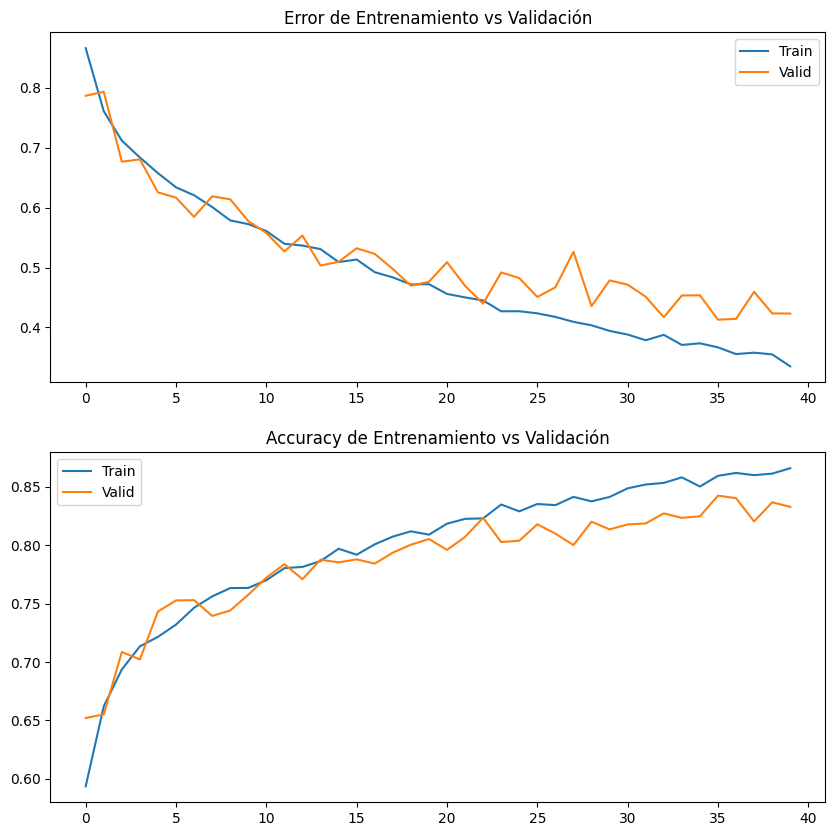

In [ ]:
%%time
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, resnet18_model_mod.parameters()),lr=0.0001)
loss = torch.nn.CrossEntropyLoss(weight=class_weights_tensor)
metric = torchmetrics.Accuracy(task='multiclass', num_classes=CANTIDAD_CLASES,average='macro' )
data = {"train": aug_train_loader, "valid": aug_valid_loader, "image_width": ANCHO_IMAGENES, "image_height": ALTO_IMAGENES}


history = train(resnet18_model_mod.to('cpu'),
                optimizer,
                loss,
                metric,
                data,
                40)

fig, axs = plt.subplots(2, 1, figsize=(10, 10))

axs[0].plot(history["train_loss"])
axs[0].plot(history["valid_loss"])
axs[0].title.set_text('Error de Entrenamiento vs Validación')
axs[0].legend(['Train', 'Valid'])

axs[1].plot(history["train_acc"])
axs[1].plot(history["valid_acc"])
axs[1].title.set_text('Accuracy de Entrenamiento vs Validación')
axs[1].legend(['Train', 'Valid'])



In [ ]:
model_name = "resnet18_lastlayer_dropout"
models_history[model_name] = history

In [ ]:
import pickle
with open('models_history.pkl', 'wb') as archivo:
    pickle.dump(models_history, archivo)

# Comparación de modelos

In [ ]:
import pickle
dbfile = open('models_history.pkl', 'rb')
model_history = pickle.load(dbfile)
dbfile.close()

In [ ]:
for model_name, history in model_history.items():
    print(model_name)

conv_dag
conv_only
vgg19_fc
resnet18_fc
resnet18_lastlayer_dropout


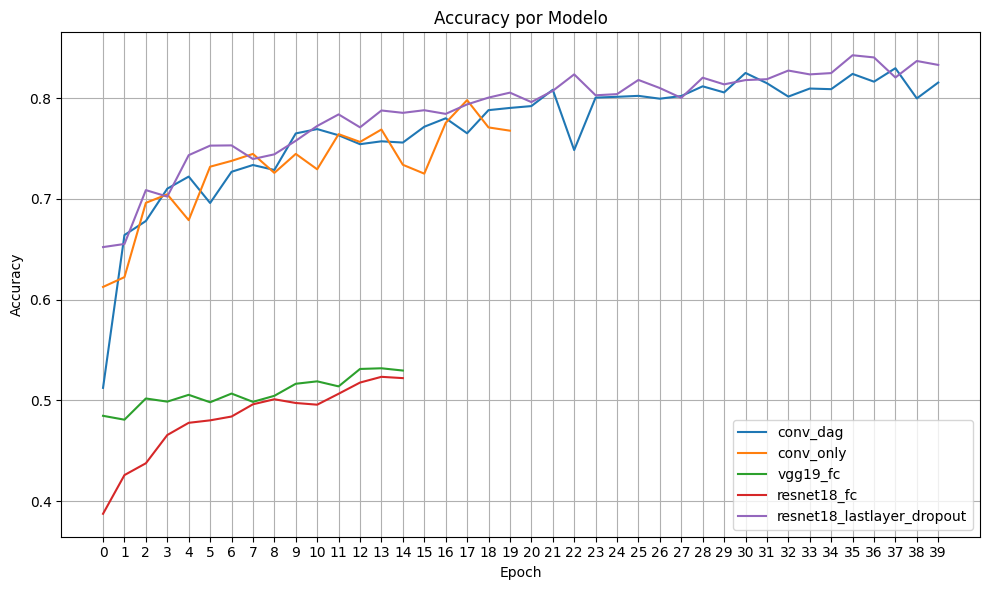

In [ ]:
import matplotlib.pyplot as plt

#Graficamos los resultados de los modelos
plt.figure(figsize=(10, 6))

for model_name, history in model_history.items():
    plt.plot(history['valid_acc'], label=model_name)


plt.title('Accuracy por Modelo')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.xticks(range(len(next(iter(model_history.values()))['valid_acc'])))
plt.tight_layout()


plt.show()


# 6. OPTIMIZACION DE HIPERPARAMETROS

Como el mejor resultado lo obtuvimos con la Resnet 18 entrenando el ultimo layer con un dropout y la fully connected, intentaremos modificar algunos hiperparametros a ver si obtenemos mejores resultados.

6.1 MODIFICACION DEL LEARNING RATE (AUMENTO)

In [33]:
from torchvision.models import resnet18, ResNet18_Weights
weights = ResNet18_Weights.IMAGENET1K_V1
transforms = weights.transforms()

In [34]:
resnet18_model = resnet18(weights=weights)

resnet18_model.to("cuda")

print(resnet18_model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [35]:
# Congelamos todas las capas inicialmente
for param in resnet18_model.parameters():
    param.requires_grad = False

# Descongelamos las capas del último bloque (layer4)
for layer in resnet18_model.layer4:
    for param in layer.parameters():
        param.requires_grad = True  # Habilitar el entrenamiento para las capas de layer4

# Descongelamos la capa final (fc) y la adaptamos
last_layer_in_features = resnet18_model.fc.in_features
resnet18_model.fc = torch.nn.Linear(in_features=last_layer_in_features, out_features=CANTIDAD_CLASES)

# Definimos un bloque básico modificado que incluye Dropout
class BasicBlockWithDropout(torch.nn.Module):

    def __init__(self, in_channels, out_channels, stride=1, downsample=None, dropout_prob=0.5):
        super(BasicBlockWithDropout, self).__init__()
        self.conv1 = torch.nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = torch.nn.BatchNorm2d(out_channels)
        self.relu = torch.nn.ReLU(inplace=True)
        self.dropout = torch.nn.Dropout(p=dropout_prob)
        self.conv2 = torch.nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = torch.nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.dropout(out)  # Aplicamos Dropout después de la ReLU

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

# Reemplazamos el layer4 en el modelo con bloques que contienen Dropout
class ModifiedResNet18(torch.nn.Module):
    def __init__(self, original_model):
        super(ModifiedResNet18, self).__init__()
        self.resnet = original_model

        # Reemplazamos el layer4 con bloques que contienen Dropout
        self.resnet.layer4 = self._replace_with_dropout(self.resnet.layer4)

    def _replace_with_dropout(self, layer4):
        new_layer4 = []
        for block in layer4:
            in_channels = block.conv1.in_channels
            out_channels = block.conv2.out_channels
            stride = block.stride
            downsample = block.downsample

            # Creamos el nuevo bloque con Dropout
            new_block = BasicBlockWithDropout(in_channels, out_channels, stride=stride, downsample=downsample, dropout_prob=0.5)
            new_layer4.append(new_block)

        return torch.nn.Sequential(*new_layer4)

    def forward(self, x):
        return self.resnet(x)

# Creamos el modelo modificado
resnet18_model_mod = ModifiedResNet18(resnet18_model)


check_requires_grad(resnet18_model_mod)

resnet.conv1.weight: requires_grad = False
resnet.bn1.weight: requires_grad = False
resnet.bn1.bias: requires_grad = False
resnet.layer1.0.conv1.weight: requires_grad = False
resnet.layer1.0.bn1.weight: requires_grad = False
resnet.layer1.0.bn1.bias: requires_grad = False
resnet.layer1.0.conv2.weight: requires_grad = False
resnet.layer1.0.bn2.weight: requires_grad = False
resnet.layer1.0.bn2.bias: requires_grad = False
resnet.layer1.1.conv1.weight: requires_grad = False
resnet.layer1.1.bn1.weight: requires_grad = False
resnet.layer1.1.bn1.bias: requires_grad = False
resnet.layer1.1.conv2.weight: requires_grad = False
resnet.layer1.1.bn2.weight: requires_grad = False
resnet.layer1.1.bn2.bias: requires_grad = False
resnet.layer2.0.conv1.weight: requires_grad = False
resnet.layer2.0.bn1.weight: requires_grad = False
resnet.layer2.0.bn1.bias: requires_grad = False
resnet.layer2.0.conv2.weight: requires_grad = False
resnet.layer2.0.bn2.weight: requires_grad = False
resnet.layer2.0.bn2.bias:

In [36]:
print(resnet18_model_mod)

ModifiedResNet18(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, t

Epoch: 1/40 - Train loss 0.854203 - Train Accuracy 0.611904 - Valid Loss 0.727478 - Valid Accuracy 0.675244
Epoch: 2/40 - Train loss 0.738803 - Train Accuracy 0.678973 - Valid Loss 0.717150 - Valid Accuracy 0.683398
Epoch: 3/40 - Train loss 0.699356 - Train Accuracy 0.703561 - Valid Loss 0.735535 - Valid Accuracy 0.680898
Epoch: 4/40 - Train loss 0.676994 - Train Accuracy 0.710020 - Valid Loss 0.629979 - Valid Accuracy 0.738402
Epoch: 5/40 - Train loss 0.632852 - Train Accuracy 0.738597 - Valid Loss 0.659337 - Valid Accuracy 0.726780
Epoch: 6/40 - Train loss 0.622592 - Train Accuracy 0.740100 - Valid Loss 0.603032 - Valid Accuracy 0.756574
Epoch: 7/40 - Train loss 0.601972 - Train Accuracy 0.754941 - Valid Loss 0.562288 - Valid Accuracy 0.770655
Epoch: 8/40 - Train loss 0.581966 - Train Accuracy 0.758331 - Valid Loss 0.626344 - Valid Accuracy 0.743093
Epoch: 9/40 - Train loss 0.564916 - Train Accuracy 0.771306 - Valid Loss 0.576417 - Valid Accuracy 0.760584
Epoch: 10/40 - Train loss 0.

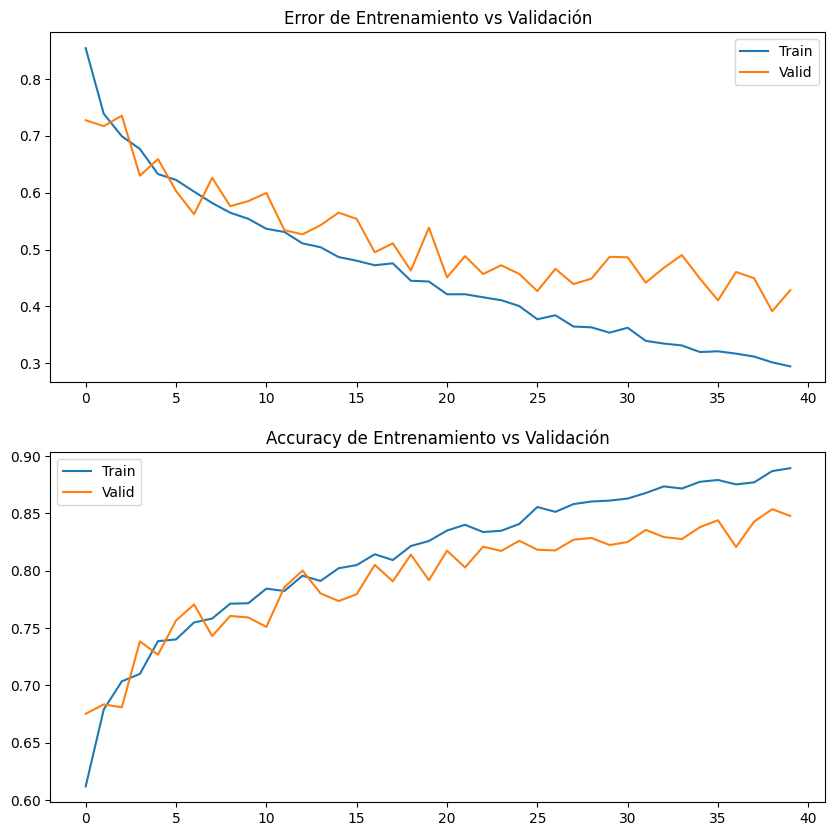

In [40]:
%%time
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, resnet18_model_mod.parameters()),lr=0.001)
loss = torch.nn.CrossEntropyLoss(weight=class_weights_tensor)
metric = torchmetrics.Accuracy(task='multiclass', num_classes=CANTIDAD_CLASES,average='macro' )
data = {"train": aug_train_loader, "valid": aug_valid_loader, "image_width": ANCHO_IMAGENES, "image_height": ALTO_IMAGENES}


history = train(resnet18_model_mod.to('cpu'),
                optimizer,
                loss,
                metric,
                data,
                40)

fig, axs = plt.subplots(2, 1, figsize=(10, 10))

axs[0].plot(history["train_loss"])
axs[0].plot(history["valid_loss"])
axs[0].title.set_text('Error de Entrenamiento vs Validación')
axs[0].legend(['Train', 'Valid'])

axs[1].plot(history["train_acc"])
axs[1].plot(history["valid_acc"])
axs[1].title.set_text('Accuracy de Entrenamiento vs Validación')
axs[1].legend(['Train', 'Valid'])



6.2 MODIFICACION DEL LEARNING RATE (DISMINUCION)

In [43]:
from torchvision.models import resnet18, ResNet18_Weights
weights = ResNet18_Weights.IMAGENET1K_V1
transforms = weights.transforms()

In [46]:
resnet18_model = resnet18(weights=weights)

resnet18_model.to("cuda")

print(resnet18_model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [47]:
# Congelamos todas las capas inicialmente
for param in resnet18_model.parameters():
    param.requires_grad = False

# Descongelamos las capas del último bloque (layer4)
for layer in resnet18_model.layer4:
    for param in layer.parameters():
        param.requires_grad = True  # Habilitar el entrenamiento para las capas de layer4

# Descongelamos la capa final (fc) y la adaptamos
last_layer_in_features = resnet18_model.fc.in_features
resnet18_model.fc = torch.nn.Linear(in_features=last_layer_in_features, out_features=CANTIDAD_CLASES)

# Definimos un bloque básico modificado que incluye Dropout
class BasicBlockWithDropout(torch.nn.Module):

    def __init__(self, in_channels, out_channels, stride=1, downsample=None, dropout_prob=0.5):
        super(BasicBlockWithDropout, self).__init__()
        self.conv1 = torch.nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = torch.nn.BatchNorm2d(out_channels)
        self.relu = torch.nn.ReLU(inplace=True)
        self.dropout = torch.nn.Dropout(p=dropout_prob)
        self.conv2 = torch.nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = torch.nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.dropout(out)  # Aplicamos Dropout después de la ReLU

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

# Reemplazamos el layer4 en el modelo con bloques que contienen Dropout
class ModifiedResNet18(torch.nn.Module):
    def __init__(self, original_model):
        super(ModifiedResNet18, self).__init__()
        self.resnet = original_model

        # Reemplazamos el layer4 con bloques que contienen Dropout
        self.resnet.layer4 = self._replace_with_dropout(self.resnet.layer4)

    def _replace_with_dropout(self, layer4):
        new_layer4 = []
        for block in layer4:
            in_channels = block.conv1.in_channels
            out_channels = block.conv2.out_channels
            stride = block.stride
            downsample = block.downsample

            # Creamos el nuevo bloque con Dropout
            new_block = BasicBlockWithDropout(in_channels, out_channels, stride=stride, downsample=downsample, dropout_prob=0.5)
            new_layer4.append(new_block)

        return torch.nn.Sequential(*new_layer4)

    def forward(self, x):
        return self.resnet(x)

# Creamos el modelo modificado
resnet18_model_mod = ModifiedResNet18(resnet18_model)


check_requires_grad(resnet18_model_mod)

resnet.conv1.weight: requires_grad = False
resnet.bn1.weight: requires_grad = False
resnet.bn1.bias: requires_grad = False
resnet.layer1.0.conv1.weight: requires_grad = False
resnet.layer1.0.bn1.weight: requires_grad = False
resnet.layer1.0.bn1.bias: requires_grad = False
resnet.layer1.0.conv2.weight: requires_grad = False
resnet.layer1.0.bn2.weight: requires_grad = False
resnet.layer1.0.bn2.bias: requires_grad = False
resnet.layer1.1.conv1.weight: requires_grad = False
resnet.layer1.1.bn1.weight: requires_grad = False
resnet.layer1.1.bn1.bias: requires_grad = False
resnet.layer1.1.conv2.weight: requires_grad = False
resnet.layer1.1.bn2.weight: requires_grad = False
resnet.layer1.1.bn2.bias: requires_grad = False
resnet.layer2.0.conv1.weight: requires_grad = False
resnet.layer2.0.bn1.weight: requires_grad = False
resnet.layer2.0.bn1.bias: requires_grad = False
resnet.layer2.0.conv2.weight: requires_grad = False
resnet.layer2.0.bn2.weight: requires_grad = False
resnet.layer2.0.bn2.bias:

Epoch: 1/40 - Train loss 0.849032 - Train Accuracy 0.619085 - Valid Loss 0.779889 - Valid Accuracy 0.644721
Epoch: 2/40 - Train loss 0.732834 - Train Accuracy 0.688625 - Valid Loss 0.668942 - Valid Accuracy 0.711255
Epoch: 3/40 - Train loss 0.694270 - Train Accuracy 0.704769 - Valid Loss 0.680823 - Valid Accuracy 0.700544
Epoch: 4/40 - Train loss 0.660432 - Train Accuracy 0.722419 - Valid Loss 0.664803 - Valid Accuracy 0.716308
Epoch: 5/40 - Train loss 0.648036 - Train Accuracy 0.734204 - Valid Loss 0.588699 - Valid Accuracy 0.754066
Epoch: 6/40 - Train loss 0.613558 - Train Accuracy 0.743072 - Valid Loss 0.607055 - Valid Accuracy 0.747881
Epoch: 7/40 - Train loss 0.603272 - Train Accuracy 0.750928 - Valid Loss 0.629284 - Valid Accuracy 0.740870
Epoch: 8/40 - Train loss 0.577359 - Train Accuracy 0.762532 - Valid Loss 0.576766 - Valid Accuracy 0.762269
Epoch: 9/40 - Train loss 0.570672 - Train Accuracy 0.772273 - Valid Loss 0.573003 - Valid Accuracy 0.767453
Epoch: 10/40 - Train loss 0.

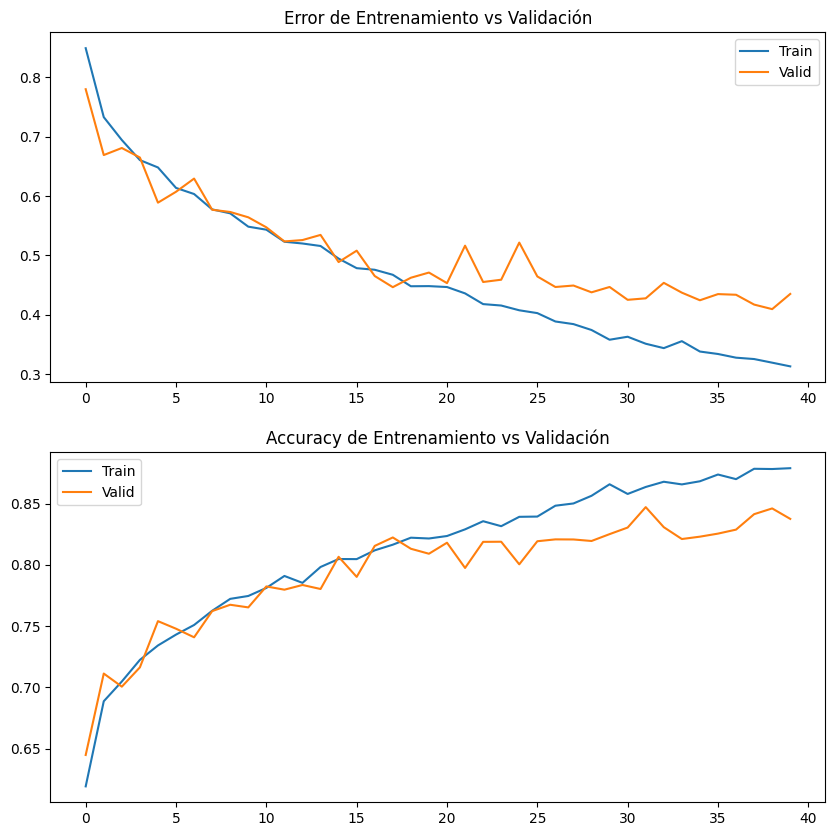

In [48]:
%%time
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, resnet18_model_mod.parameters()),lr=0.0005)
loss = torch.nn.CrossEntropyLoss(weight=class_weights_tensor)
metric = torchmetrics.Accuracy(task='multiclass', num_classes=CANTIDAD_CLASES,average='macro' )
data = {"train": aug_train_loader, "valid": aug_valid_loader, "image_width": ANCHO_IMAGENES, "image_height": ALTO_IMAGENES}


history = train(resnet18_model_mod.to('cpu'),
                optimizer,
                loss,
                metric,
                data,
                40)

fig, axs = plt.subplots(2, 1, figsize=(10, 10))

axs[0].plot(history["train_loss"])
axs[0].plot(history["valid_loss"])
axs[0].title.set_text('Error de Entrenamiento vs Validación')
axs[0].legend(['Train', 'Valid'])

axs[1].plot(history["train_acc"])
axs[1].plot(history["valid_acc"])
axs[1].title.set_text('Accuracy de Entrenamiento vs Validación')
axs[1].legend(['Train', 'Valid'])



6.3 MODIFICAMOS EL BATCH_SIZE

In [58]:
# Creamos los DataLoaders
aug_train_loader = DataLoader(aug_train_set, batch_size=128, shuffle=True)
aug_valid_loader = DataLoader(aug_valid_set, batch_size=128, shuffle=False)

In [59]:
from torchvision.models import resnet18, ResNet18_Weights
weights = ResNet18_Weights.IMAGENET1K_V1
transforms = weights.transforms()

In [60]:
resnet18_model = resnet18(weights=weights)

resnet18_model.to("cuda")

print(resnet18_model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [61]:
# Congelamos todas las capas inicialmente
for param in resnet18_model.parameters():
    param.requires_grad = False

# Descongelamos las capas del último bloque (layer4)
for layer in resnet18_model.layer4:
    for param in layer.parameters():
        param.requires_grad = True  # Habilitar el entrenamiento para las capas de layer4

# Descongelamos la capa final (fc) y la adaptamos
last_layer_in_features = resnet18_model.fc.in_features
resnet18_model.fc = torch.nn.Linear(in_features=last_layer_in_features, out_features=CANTIDAD_CLASES)

# Definimos un bloque básico modificado que incluye Dropout
class BasicBlockWithDropout(torch.nn.Module):

    def __init__(self, in_channels, out_channels, stride=1, downsample=None, dropout_prob=0.5):
        super(BasicBlockWithDropout, self).__init__()
        self.conv1 = torch.nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = torch.nn.BatchNorm2d(out_channels)
        self.relu = torch.nn.ReLU(inplace=True)
        self.dropout = torch.nn.Dropout(p=dropout_prob)
        self.conv2 = torch.nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = torch.nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.dropout(out)  # Aplicamos Dropout después de la ReLU

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

# Reemplazamos el layer4 en el modelo con bloques que contienen Dropout
class ModifiedResNet18(torch.nn.Module):
    def __init__(self, original_model):
        super(ModifiedResNet18, self).__init__()
        self.resnet = original_model

        # Reemplazamos el layer4 con bloques que contienen Dropout
        self.resnet.layer4 = self._replace_with_dropout(self.resnet.layer4)

    def _replace_with_dropout(self, layer4):
        new_layer4 = []
        for block in layer4:
            in_channels = block.conv1.in_channels
            out_channels = block.conv2.out_channels
            stride = block.stride
            downsample = block.downsample

            # Creamos el nuevo bloque con Dropout
            new_block = BasicBlockWithDropout(in_channels, out_channels, stride=stride, downsample=downsample, dropout_prob=0.5)
            new_layer4.append(new_block)

        return torch.nn.Sequential(*new_layer4)

    def forward(self, x):
        return self.resnet(x)

# Creamos el modelo modificado
resnet18_model_mod = ModifiedResNet18(resnet18_model)


check_requires_grad(resnet18_model_mod)

resnet.conv1.weight: requires_grad = False
resnet.bn1.weight: requires_grad = False
resnet.bn1.bias: requires_grad = False
resnet.layer1.0.conv1.weight: requires_grad = False
resnet.layer1.0.bn1.weight: requires_grad = False
resnet.layer1.0.bn1.bias: requires_grad = False
resnet.layer1.0.conv2.weight: requires_grad = False
resnet.layer1.0.bn2.weight: requires_grad = False
resnet.layer1.0.bn2.bias: requires_grad = False
resnet.layer1.1.conv1.weight: requires_grad = False
resnet.layer1.1.bn1.weight: requires_grad = False
resnet.layer1.1.bn1.bias: requires_grad = False
resnet.layer1.1.conv2.weight: requires_grad = False
resnet.layer1.1.bn2.weight: requires_grad = False
resnet.layer1.1.bn2.bias: requires_grad = False
resnet.layer2.0.conv1.weight: requires_grad = False
resnet.layer2.0.bn1.weight: requires_grad = False
resnet.layer2.0.bn1.bias: requires_grad = False
resnet.layer2.0.conv2.weight: requires_grad = False
resnet.layer2.0.bn2.weight: requires_grad = False
resnet.layer2.0.bn2.bias:

Epoch: 1/40 - Train loss 0.601939 - Train Accuracy 0.748376 - Valid Loss 0.765038 - Valid Accuracy 0.693943
Epoch: 2/40 - Train loss 0.586027 - Train Accuracy 0.760168 - Valid Loss 0.533467 - Valid Accuracy 0.781471
Epoch: 3/40 - Train loss 0.568074 - Train Accuracy 0.765207 - Valid Loss 0.530138 - Valid Accuracy 0.781326
Epoch: 4/40 - Train loss 0.540738 - Train Accuracy 0.777496 - Valid Loss 0.533416 - Valid Accuracy 0.774530
Epoch: 5/40 - Train loss 0.527184 - Train Accuracy 0.785768 - Valid Loss 0.533220 - Valid Accuracy 0.781918
Epoch: 6/40 - Train loss 0.512222 - Train Accuracy 0.788994 - Valid Loss 0.552838 - Valid Accuracy 0.784122
Epoch: 7/40 - Train loss 0.497127 - Train Accuracy 0.798442 - Valid Loss 0.579931 - Valid Accuracy 0.770096
Epoch: 8/40 - Train loss 0.490650 - Train Accuracy 0.802479 - Valid Loss 0.518033 - Valid Accuracy 0.801476
Epoch: 9/40 - Train loss 0.481557 - Train Accuracy 0.799561 - Valid Loss 0.498480 - Valid Accuracy 0.794337
Epoch: 10/40 - Train loss 0.

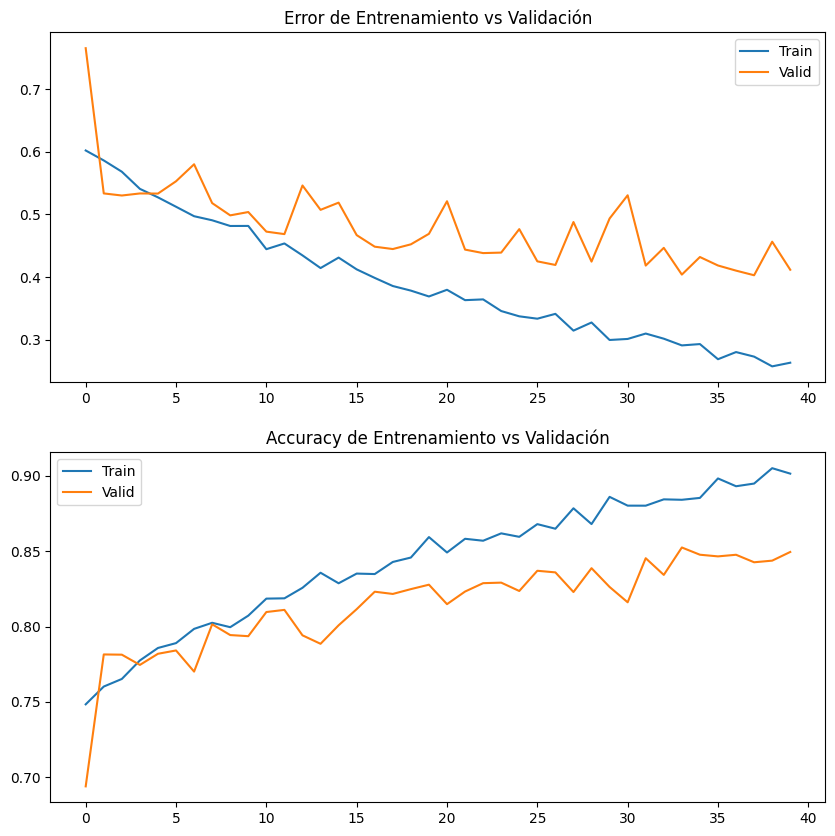

In [63]:
%%time
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, resnet18_model_mod.parameters()),lr=0.001)
loss = torch.nn.CrossEntropyLoss(weight=class_weights_tensor)
metric = torchmetrics.Accuracy(task='multiclass', num_classes=CANTIDAD_CLASES,average='macro' )
data = {"train": aug_train_loader, "valid": aug_valid_loader, "image_width": ANCHO_IMAGENES, "image_height": ALTO_IMAGENES}


history = train(resnet18_model_mod.to('cpu'),
                optimizer,
                loss,
                metric,
                data,
                40)

fig, axs = plt.subplots(2, 1, figsize=(10, 10))

axs[0].plot(history["train_loss"])
axs[0].plot(history["valid_loss"])
axs[0].title.set_text('Error de Entrenamiento vs Validación')
axs[0].legend(['Train', 'Valid'])

axs[1].plot(history["train_acc"])
axs[1].plot(history["valid_acc"])
axs[1].title.set_text('Accuracy de Entrenamiento vs Validación')
axs[1].legend(['Train', 'Valid'])



Conclusiones:
- El modelo customizado dio muy buenos resultados tanto sin data augmentation como con data augmentation, siendo levemente mejor estos ultimos.
- Los modelos con transfer learning pero modificando unicamente la fully connected daban muy malos resultados.
- La modificación de hiperparametros que hicimos no modificó sustancialmente los resultados que veníamos obteniendo.
- El modelo que mejores resultados obtuvo en términos de performance y de overfitting fue hacer un transfer learning desde la resnet 18 modificando el layer 4 y la capa fully connected y modificando el learning rate (0.001)